In [149]:
from cluster import KMeans, make_clusters
import numpy as np
from scipy.spatial.distance import cdist
from collections import defaultdict
from matplotlib import pyplot as plt

In [265]:
from cluster import KMeans
class Kplusplus(KMeans):
    def fit(self, mat: np.ndarray):
        """
        Fits the kmeans algorithm onto a provided 2D matrix.
        As a bit of background, this method should not return anything.
        The intent here is to have this method find the k cluster centers from the data
        with the tolerance, then you will use .predict() to identify the
        clusters that best match some data that is provided.

        In sklearn there is also a fit_predict() method that combines these
        functions, but for now we will have you implement them both separately.

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features
        """
        # Create an initial centroid
        self._generate_init_centroid(mat)

        # Generate k centroids
        self._generate_k_centroids(mat)

        # Calculate the sum of squares error for this first set of k centroids
        prev_error = self._generate_error_per_centroid(mat)

        # No other error here so set error_diff to prev_error
        curr_error = prev_error

        error_diff_dict = {}

        for key in curr_error:
            error_diff_dict[key] = np.absolute((prev_error[key])[0] - (curr_error[key])[0])

        # max_iter - 1 because already went through one iteration
        for i in range(self.max_iter-1):
            for values in error_diff_dict.values():
                if float(values) > self.tol:
                    self._update_centroids(mat)
                else:
                    break


    def predict(self, mat: np.ndarray) -> np.ndarray:
        """
        Predicts the cluster labels for a provided matrix of data points--
            question: what sorts of data inputs here would prevent the code from running?
            How would you catch these sorts of end-user related errors?
            What if, for example, the matrix is of a different number of features than
            the data that the clusters were fit on?

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features

        outputs:
            np.ndarray
                a 1D array with the cluster label for each of the observations in `mat`
        """
        try:
            mat.ndim == 2
        except TypeError:
            print('Incorrect number of dimensions:' + mat.ndim)

        new_assign = self._assign_cluster(mat)

        for key, data_list in new_assign.items():
            key, values = zip(*data_list)  # Unpack
            plt.scatter(key, values, label=key)
        plt.show()

    def get_error(self) -> float:
        """
        Returns the final squared-mean error of the fit model. You can either do this by storing the
        original dataset or recording it following the end of model fitting.

        outputs:
            float
                the squared-mean error of the fit model
        """


    def get_centroids(self) -> np.ndarray:
        """
        Returns the centroid locations of the fit model.

        outputs:
            np.ndarray
                a `k x m` 2D matrix representing the cluster centroids of the fit model
        """
        return self.centroids

    def _generate_init_centroid(self, mat: np.ndarray):
        self.centroids = []
        initial_index = np.random.choice(range(mat.shape[0]), )
        self.centroids.append(mat[initial_index, :].tolist())

    def distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared
        return self.dist_squared

    def _distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared

    def _choose_next_centroid(self, mat: np.ndarray):
        self.probs = self.dist_squared / self.dist_squared.sum()
        self.cumulative_probs = self.probs.cumsum()
        r = np.random.uniform(low=0.0, high=1.0)
        index = np.where(self.cumulative_probs >= r)[0][0]
        return mat[index]

    def _generate_k_centroids(self, mat: np.ndarray):
        self._generate_init_centroid(mat)
        while len(self.centroids) < self.k:
            self._distance_from_centroids(mat)
            self.centroids.append(self._choose_next_centroid(mat))
        self.centroids = np.array(self.centroids)

    def _determine_error(self, mat: np.ndarray) -> np.ndarray:
        centroids = self.get_centroids()
        sum_of_squares_error = np.array([np.square([np.sum((m-c)**2) for c in centroids]) for m in mat])
        return sum_of_squares_error

    def _assign_cluster(self, mat: np.ndarray) -> defaultdict:

        # I created a dictionary assigning each point to the centroid for which error is minimum
        assignment_dict = defaultdict(list)

        error = self._determine_error(mat)

        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            assignment_dict[min_dist_index].append(mat[index])

        return assignment_dict

    def _update_centroids(self, mat: np.ndarray):
        # Creates a dictionary in which keys are centroids and values are the data points assigned to them
        class_dict = self._assign_cluster(mat)

        # Initialize a dictionary with mean coordinates for each cluster center
        mean_dict = defaultdict(list)

        # Iterate through the k keys
        for i in class_dict.keys():
            # Pass the values of class_dict into a list and assign to dict_values
            dict_values = list(class_dict.values())

            # Select the values corresponding to the ith key
            dict_values_curr = dict_values[i]

            # Take the mean of all the n observations and m features across each data point in a particular cluster
            dict_val_mean = map(np.mean, zip(*dict_values_curr))

            # Make dict_val_mean a list
            dict_val_mean = list(dict_val_mean)

            # Append mean_dict with the mean associated with the m and n values
            mean_dict[i].append(dict_val_mean)

        # Reset self.centroids to be empty
        self.centroids = []

        # Loop through the number of centroids until you have added k centroids
        while len(self.centroids) < self.k:

            # Iterate through mean_dict
            for key, value in mean_dict.items():
                # Assign the k key values to be indices for the self.centroids array
                index = key
                # Insert the associated mean values to a specific index
                self.centroids.insert(index, value)

        # Reshape self.centroids array to be m x n dimensions
        self.centroids = np.squeeze(np.array(self.centroids), axis=(1,))

    def _generate_error_per_centroid(self, mat: np.ndarray):
        # Returns dictionary of summed errors per cluster
        error_dict = defaultdict(list)
        error = self._determine_error(mat)
        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            error_dict[min_dist_index].append(val[min_dist_index])

        # Calculate error of all assigned points in a particular cluster
        sum_errors_dict = {k: [sum(error_dict[k])] for k in error_dict.keys()}

        return sum_errors_dict
    
    def _return_matrix_of_labels(self, mat: np.ndarray):
        labels = []
        error = self._determine_error(mat)
        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            labels.append(min_dist_index)
        labels = np.array(labels)

        print(labels)

In [266]:
kmeansplusplus = Kplusplus(5, tol=1e-6, max_iter=100)
mat, labels = make_clusters(n=1000, m=2, k=5)

In [267]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [268]:
kmeansplusplus.fit(mat)

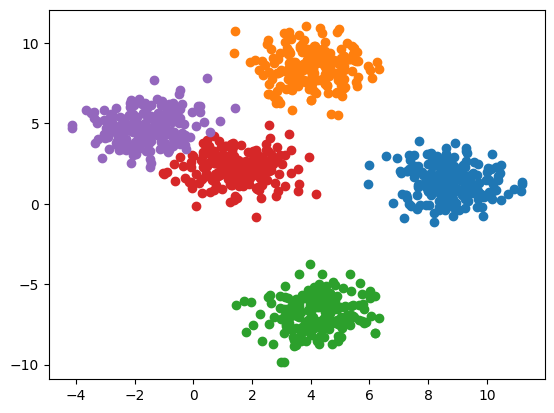

In [269]:
kmeansplusplus.predict(mat)

In [270]:
new_assign = kmeansplusplus._assign_cluster(mat)

In [271]:
print(new_assign)

defaultdict(<class 'list'>, {0: [array([7.65276083, 1.17687675]), array([8.69809056, 2.39685519]), array([6.94990102, 2.83221399]), array([8.48435775, 0.8757826 ]), array([ 7.63026127, -0.352193  ]), array([9.46553623, 1.37598164]), array([7.35240475, 0.0075849 ]), array([8.30658095, 2.9716852 ]), array([ 8.3827743 , -0.20047928]), array([8.39662259, 1.0299401 ]), array([5.94547901, 1.24836881]), array([8.41143112, 1.99887004]), array([10.49132174,  2.4292287 ]), array([8.37347696, 0.19613776]), array([11.21572545,  1.36188211]), array([8.65629494, 1.27853858]), array([8.84045041, 1.15830326]), array([8.06870364, 0.75580473]), array([8.60961238, 0.7592389 ]), array([7.92951987, 1.4090939 ]), array([8.38738843, 2.80665666]), array([5.99139584, 2.39417052]), array([ 9.88845084, -0.77072656]), array([8.29967806, 0.93122281]), array([7.23485395, 0.52484698]), array([7.5317898 , 3.05493412]), array([9.57804404, 2.57421877]), array([9.36403771, 0.1736119 ]), array([8.11784538, 1.79203823]), 

In [272]:
new_assign_vstack = np.vstack(list(new_assign.values()))

In [273]:
new_assign_vstack

array([[ 7.65276083,  1.17687675],
       [ 8.69809056,  2.39685519],
       [ 6.94990102,  2.83221399],
       ...,
       [-0.81288003,  5.5179414 ],
       [-1.43355995,  6.13934386],
       [-1.10762378,  3.8677968 ]])

In [274]:
for i in range(len(mat)):
    print(mat[i])

[7.65276083 1.17687675]
[8.69809056 2.39685519]
[6.94990102 2.83221399]
[8.48435775 0.8757826 ]
[ 7.63026127 -0.352193  ]
[9.46553623 1.37598164]
[7.35240475 0.0075849 ]
[8.30658095 2.9716852 ]
[ 8.3827743  -0.20047928]
[8.39662259 1.0299401 ]
[5.94547901 1.24836881]
[8.41143112 1.99887004]
[10.49132174  2.4292287 ]
[8.37347696 0.19613776]
[11.21572545  1.36188211]
[8.65629494 1.27853858]
[8.84045041 1.15830326]
[8.06870364 0.75580473]
[8.60961238 0.7592389 ]
[7.92951987 1.4090939 ]
[8.38738843 2.80665666]
[5.99139584 2.39417052]
[ 9.88845084 -0.77072656]
[8.29967806 0.93122281]
[7.23485395 0.52484698]
[7.5317898  3.05493412]
[9.57804404 2.57421877]
[9.36403771 0.1736119 ]
[8.11784538 1.79203823]
[7.42023784 2.0156621 ]
[8.40204025 0.92784286]
[9.35332562 1.74692698]
[8.28139948 2.46199348]
[7.56130232 1.91859928]
[9.23546691 0.99311723]
[8.96849867 0.0515501 ]
[9.56639267 1.11776154]
[8.11964263 2.3516729 ]
[ 7.93802196 -0.10579762]
[7.08573648 1.90867362]
[7.3619363  3.05745785]
[6.5

In [275]:
for i in range(len(new_assign_vstack)):
    print(new_assign_vstack[i])

[7.65276083 1.17687675]
[8.69809056 2.39685519]
[6.94990102 2.83221399]
[8.48435775 0.8757826 ]
[ 7.63026127 -0.352193  ]
[9.46553623 1.37598164]
[7.35240475 0.0075849 ]
[8.30658095 2.9716852 ]
[ 8.3827743  -0.20047928]
[8.39662259 1.0299401 ]
[5.94547901 1.24836881]
[8.41143112 1.99887004]
[10.49132174  2.4292287 ]
[8.37347696 0.19613776]
[11.21572545  1.36188211]
[8.65629494 1.27853858]
[8.84045041 1.15830326]
[8.06870364 0.75580473]
[8.60961238 0.7592389 ]
[7.92951987 1.4090939 ]
[8.38738843 2.80665666]
[5.99139584 2.39417052]
[ 9.88845084 -0.77072656]
[8.29967806 0.93122281]
[7.23485395 0.52484698]
[7.5317898  3.05493412]
[9.57804404 2.57421877]
[9.36403771 0.1736119 ]
[8.11784538 1.79203823]
[7.42023784 2.0156621 ]
[8.40204025 0.92784286]
[9.35332562 1.74692698]
[8.28139948 2.46199348]
[7.56130232 1.91859928]
[9.23546691 0.99311723]
[8.96849867 0.0515501 ]
[9.56639267 1.11776154]
[8.11964263 2.3516729 ]
[ 7.93802196 -0.10579762]
[7.08573648 1.90867362]
[7.3619363  3.05745785]
[6.5

In [276]:
new_assign.get(np.array(mat[0][0]))

TypeError: unhashable type: 'numpy.ndarray'

In [277]:
np.array(mat[0])

array([7.65276083, 1.17687675])

In [278]:
new_assign[0][0]

array([7.65276083, 1.17687675])

In [279]:
new_assign.get(0)

[array([7.65276083, 1.17687675]),
 array([8.69809056, 2.39685519]),
 array([6.94990102, 2.83221399]),
 array([8.48435775, 0.8757826 ]),
 array([ 7.63026127, -0.352193  ]),
 array([9.46553623, 1.37598164]),
 array([7.35240475, 0.0075849 ]),
 array([8.30658095, 2.9716852 ]),
 array([ 8.3827743 , -0.20047928]),
 array([8.39662259, 1.0299401 ]),
 array([5.94547901, 1.24836881]),
 array([8.41143112, 1.99887004]),
 array([10.49132174,  2.4292287 ]),
 array([8.37347696, 0.19613776]),
 array([11.21572545,  1.36188211]),
 array([8.65629494, 1.27853858]),
 array([8.84045041, 1.15830326]),
 array([8.06870364, 0.75580473]),
 array([8.60961238, 0.7592389 ]),
 array([7.92951987, 1.4090939 ]),
 array([8.38738843, 2.80665666]),
 array([5.99139584, 2.39417052]),
 array([ 9.88845084, -0.77072656]),
 array([8.29967806, 0.93122281]),
 array([7.23485395, 0.52484698]),
 array([7.5317898 , 3.05493412]),
 array([9.57804404, 2.57421877]),
 array([9.36403771, 0.1736119 ]),
 array([8.11784538, 1.79203823]),
 arr

In [280]:
new_assign.get(1)

[array([-0.24726526,  3.39622243]),
 array([-0.60990701,  5.27204946]),
 array([-1.49374495,  2.31815047]),
 array([-0.68609471,  3.66773463]),
 array([0.58233522, 4.48185901]),
 array([-1.87572673,  4.08134291]),
 array([-0.7731946 ,  4.54766054]),
 array([-2.16675961,  6.05018874]),
 array([-0.09778357,  4.12846115]),
 array([-3.38392653,  5.7363984 ]),
 array([-2.2020164 ,  5.51951031]),
 array([-3.48749039,  5.62148205]),
 array([-2.7285585 ,  5.45964883]),
 array([-1.50311351,  3.77494529]),
 array([-1.92442289,  5.41520317]),
 array([-1.41149212,  5.31329769]),
 array([0.099826  , 4.83324065]),
 array([-2.41617062,  3.39857109]),
 array([-1.70650696,  5.65053482]),
 array([-1.64493569,  6.24003964]),
 array([-2.96856226,  4.71679576]),
 array([-2.76978002,  5.0925166 ]),
 array([-0.63049918,  4.30812292]),
 array([-4.12160043,  4.92783286]),
 array([-1.08064802,  5.13317947]),
 array([-0.28160438,  3.65783103]),
 array([-0.83717047,  5.92139222]),
 array([-3.29597416,  5.04853654

In [281]:
kmeansplusplus._determine_error(mat)

array([[2.24003039e-01, 1.04058350e+04, 4.76631665e+03, 7.19174935e+03,
        1.11932449e+03],
       [7.12125401e-01, 1.28765675e+04, 3.35037114e+03, 1.35176397e+04,
        2.07695734e+03],
       [6.73245277e+00, 6.14202890e+03, 1.80474300e+03, 1.18528859e+04,
        6.47355993e+02],
       ...,
       [8.82789095e+03, 2.69071840e-01, 2.17276877e+03, 2.98077881e+04,
        3.59574957e+02],
       [1.22172970e+04, 3.11521648e-01, 2.52299512e+03, 3.76583908e+04,
        7.47860400e+02],
       [7.99680613e+03, 6.31467367e+00, 4.16679437e+03, 1.86986362e+04,
        1.51245045e+02]])

In [282]:
kmeansplusplus._generate_error_per_centroid(mat)

{0: [2167.6399469938942],
 2: [4113.008164209604],
 3: [2560.1753670067646],
 4: [1661.9271508729955],
 1: [1855.4992793612469]}

In [283]:
error_dict = []
error = kmeansplusplus._determine_error(mat)
for index, val in enumerate(error):
    min_dist_index = np.argmin(error[index])
    error_dict.append(min_dist_index)
    np.array(error_dict)

In [284]:
print(error_dict)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [285]:
kmeansplusplus._return_matrix_of_labels(mat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 